# Batch computation

This notebook computes event rate at T2K and PS191 throughout the parameter space. Sometimes we compute the lifetime as well.

In [1]:
import numpy as np
from scipy import interpolate

import pathos.multiprocessing as mp
from pathos.multiprocessing import ProcessingPool as Pool

from functools import partial

from particle import *
from particle import literals as lp

from hnl_apps import *
from hnl_apps.plot_tools import *
from hnl_apps.const import *

from Nlimits import *
from Nlimits.constraint_dict import *
from Nlimits.plotter import *

# Minimal version

In [2]:
# set up grid
gridx = 100
gridy = 50

M4 = np.linspace(0.02,(m_neutral_kaon - m_mu), gridx)
USQR = np.logspace(-9,-2, gridy) 
X,Y = np.meshgrid(M4,USQR)
m4_grid, usqr_grid = X.flatten(), Y.flatten()

### mu-pi

In [37]:
# compute rate and lifetimes
tot_cores = mp.cpu_count()
pool = Pool(tot_cores)
############

get_event_partial = partial(hnl_tools.get_event_rate_mode, modes=['nu_e_mu', 'mu_pi'], flavor_struct=[0.0,1.0,0.0], detector = ps191)
event_rate_weak_ps191 = pool.map(get_event_partial, ((m4, usqr) for m4, usqr in zip(m4_grid, usqr_grid)))

############
pool.terminate()
pool.restart()

<multiprocess.pool.Pool state=RUN pool_size=8>

In [38]:
event_rate_weak_ps191_e_mu = np.array(event_rate_weak_ps191)[:,0]
event_rate_weak_ps191_mu_pi = np.array(event_rate_weak_ps191)[:,1]

In [39]:
# Save to file
table_PS191_minimal = np.array([m4_grid, usqr_grid, event_rate_weak_ps191_e_mu, event_rate_weak_ps191_mu_pi])
np.save("limits_computed/PS191_minimal_Umu4__mode__others",table_PS191_minimal)
np.savetxt("limits_computed/PS191_minimal_Umu4__mode__others.dat",table_PS191_minimal, header=" m4(GeV) USQR event_rate")

### load it

In [41]:
table_ps191 = np.load("limits_computed/PS191_minimal_Umu4__mode__others.npy", allow_pickle=True)
m4_grid_ps191, usqr_grid_ps191, event_rate_weak_ps191_e_mu, event_rate_weak_ps191_mu_pi = table_ps191

<ipython-input-69-2f0333389b14>:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.array([20,40,60,80,100,150, 200,400]))


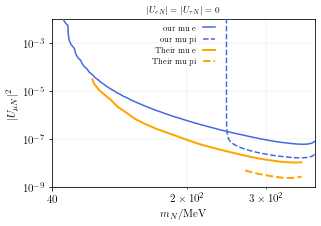

In [69]:
######
fig, ax = std_fig(ax_form= [0.15,0.16,0.82,0.76])

# HNL mass span
x = np.logspace(np.log10(20),np.log10((m_neutral_kaon - m_mu)*1e3), 1000, endpoint=True)

############################################
# our PS191 bound (our own calculation)
Xi,Yi,Zi=interp_grid(x=m4_grid_ps191*1e3, y=usqr_grid_ps191 , z=event_rate_weak_ps191_e_mu, logx=False, logy=True)
level_0 = contour(Xi, Yi, Zi, levels = [2.3], colors=['royalblue'], linewidths=[0], zorder=10) #NEW CONSTRAINT
bound_e_mu = level_0.collections[0].get_paths()[0].vertices  #grab the coords of the bound
ax.plot(bound_e_mu[:,0],bound_e_mu[:,1], c='royalblue',  lw=1.5, zorder=10, rasterized=True, label='our mu e')

############################################
# our PS191 bound (our own calculation)
Xi,Yi,Zi=interp_grid(x=m4_grid_ps191*1e3, y=usqr_grid_ps191 , z=event_rate_weak_ps191_mu_pi, logx=False, logy=True)
level_0 = contour(Xi, Yi, Zi, levels = [2.3], colors=['royalblue'], linewidths=[0], zorder=10) #NEW CONSTRAINT
bound_mu_pi = level_0.collections[0].get_paths()[0].vertices  #grab the coords of the bound
ax.plot(bound_mu_pi[:,0],bound_mu_pi[:,1], c='royalblue',  lw=1.5, zorder=10, ls='--', rasterized=True, label='our mu pi')


mn_mu_e, umu42_mu_e = np.genfromtxt("digitized/PS_191/umu4SQR_nu_mu_e.dat", unpack=True)
ax.plot(mn_mu_e, umu42_mu_e, lw=2, c='orange', label = r'Their mu e')

mn_mu_pi, umu42_mu_pi = np.genfromtxt("digitized/PS_191/umu4SQR_mu_pi.dat", unpack=True)
ax.plot(mn_mu_pi, umu42_mu_pi, lw=2, c='orange', label = r'Their mu pi',ls='--')

####
# labels
ax.set_title(r"$|U_{e N}| = |U_{\tau N}| = 0$",fontsize=9)
ax.legend(loc='upper center', markerfirst=False, frameon=False, handlelength=1.6,
          framealpha=0.9, borderpad=0.2, edgecolor='None', facecolor='white', ncol=1, fontsize=8)

ax.set_xlim(100,np.max(x))
ax.set_ylim(1e-9,1e-2)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"$|U_{\mu N}|^2$")
ax.set_xlabel(r"$m_{N}$/MeV")

# ax.set_xticks(np.array([20, 40, 60, 80, 100, 150, 200, 400]))
ax.set_xticklabels(np.array([20,40,60,80,100,150, 200,400]))
ax.grid(axis='y', which='both',dashes=(6,1),alpha=0.5,c='black',lw=0.1)
ax.grid(axis='x', which='both',dashes=(6,1),alpha=0.5,c='black',lw=0.1)
fig.savefig('plots/weak_decays_other_channels.pdf', dpi=300)
fig.savefig('plots/weak_decays_other_channels.png', dpi=300)



In [60]:
mine = interpolate.interp1d(bound_e_mu[:,0], bound_e_mu[:,1], bounds_error= False, fill_value=np.inf)
theirs=interpolate.interp1d(mn_mu_e, umu42_mu_e, bounds_error= False, fill_value=np.inf)
x = np.linspace(40,400,40 )
mine(x)/theirs(x)

<ipython-input-60-d2e750ed4181>:4: RuntimeWarning: invalid value encountered in true_divide
  mine(x)/theirs(x)


array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan, 0.        , 1.64621533,
       2.53138869, 3.8231285 , 4.56395446, 5.46785053, 5.66819018,
       5.54826838, 5.90767926, 6.13144258, 6.4013163 , 6.649935  ,
       6.70816448, 6.61379745, 6.64945735, 6.78346581, 6.72325039,
       6.83419812, 6.74360731, 6.76414981, 6.70054417, 6.60023642,
       6.50813433, 6.41843674, 6.26492069, 6.05241853, 5.80088093,
       0.        , 0.        , 0.        ,        nan,        nan])

In [61]:
mine = interpolate.interp1d(bound_mu_pi[:,0], bound_mu_pi[:,1], bounds_error= False, fill_value=np.inf)
theirs=interpolate.interp1d(mn_mu_pi, umu42_mu_pi, bounds_error= False, fill_value=np.inf)
x = np.linspace(40, 400, 40)
mine(x)/theirs(x)

<ipython-input-61-0336af014098>:4: RuntimeWarning: invalid value encountered in true_divide
  mine(x)/theirs(x)


array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan, 0.        , 0.        ,
       7.5818476 , 7.60518136, 7.58605793, 7.55368233, 7.53876833,
       7.59437052, 7.61599989, 7.37800347, 6.97712841, 6.44558865,
       0.        , 0.        , 0.        ,        nan,        nan])